In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os, sys

sys.path.insert(0,'../')
from src.utils import load_config, split_into_sentences, flatten_list
from src.stats_analysis import compute_pearson_table, compute_anova_table, compute_wilc_table

import matplotlib.pyplot as plt

config = load_config('../config.yaml')

[nltk_data] Downloading package punkt to /home/robin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from src.data_cleaning import add_average_data

data = pd.read_pickle(os.path.join(config['data_isaac']['folder'],config['data_isaac']['features_file']))

data = add_average_data(data)


routine = data[data['Stim1']=="routine"]
cinderella = data[data['Stim1']=="cinderella"]


factors = ['NegAff', 'NegFTD', 'Eccentric', 'SocAnx', 'PosFTD', "OCD","ADHD","Constrict","VivPercept","F1","F2"]

#factors = ['NegAff', 'NegFTD', 'Eccentric', 'SocAnx', 'PosFTD']

factor_rename_map = {
    'NegFTD': 'Reduced speech',
    'PosFTD': 'Disorganized speech',
    'SocAnx': 'Social Anxiety',
    'NegAff': 'Negative Affect',
    'Eccentric': 'Eccentricity'
}



merged_df = pd.merge(cinderella, routine, on='subj', suffixes=('_cinderella', '_routine'))




In [3]:
print(len(routine))

969


In [4]:
print(len(cinderella))

826


In [3]:
len(merged_df)

811

In [4]:
merged_df.columns.to_list()

['subj',
 'Stim1_cinderella',
 'story_cinderella',
 'OCD_cinderella',
 'Cog&Percept_cinderella',
 'SocAnx_cinderella',
 'Eccentric_cinderella',
 'ADHD_cinderella',
 'Constrict_cinderella',
 'PosFTD_cinderella',
 'NegAff_cinderella',
 'NegFTD_cinderella',
 'HypoMania_cinderella',
 'VivPercept_cinderella',
 'F1_cinderella',
 'F2_cinderella',
 'cleaned_story_2_cinderella',
 'sentences_cinderella',
 'num_sentences_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_cinderella',
 'w2v_all_cosine_sentences_similarity_cinderella',
 'w2v_vectors_cinderella',
 'w2vwords_cinderella',
 'w2v_consecutive_wmd_sentences_similarity_cinderella',
 'w2v_all_wmd_sentences_similarity_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_mean_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_median_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_std_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_min_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_max_ci

In [3]:
all_cosine_sentences_similarity_mean = data.filter(regex = '_all_cosine_sentences_similarity_mean').columns.tolist()
#all_cosine_sentences_similarity_std = data.filter(regex = 'all_cosine_sentences_similarity_std').columns.tolist()
all_wmd_sentences_similarity_mean = data.filter(regex = '_all_wmd_sentences_similarity_mean').columns.tolist()
# all_wmd_sentences_similarity_std = data.filter(regex = 'all_wmd_sentences_similarity_std').columns.tolist()


#consecutive_cosine_sentences_similarity_mean = data.filter(regex = 'consecutive_cosine_sentences_similarity_mean').columns.tolist()
#consecutive_cosine_sentences_similarity_std = data.filter(regex = 'consecutive_cosine_sentences_similarity_std').columns.tolist()
    

Structural_density = [
                        'cluster_density_score_HDBSCAN', 
                        'cluster_reverse_silhouette_score_HDBSCAN',
                        'cluster_density_score_MeanShift', 
                        'cluster_reverse_silhouette_score_MeanShift',
                        'reduction_score_PCA_explained_variance', 
                        'reduction_score_PCA_prop_of_components',]

Semantic_contribution = ['regression_coef_density_score_Lasso',
    'regression_error_score_Lasso',
    'reduction_score_Lasso',
    ]

silhouette_based = ['cluster_reverse_silhouette_score_MeanShift', 'cluster_reverse_silhouette_score_HDBSCAN']
cluster_density_based = ['cluster_density_score_MeanShift', "cluster_density_score_HDBSCAN" ]
pca_based = ['reduction_score_PCA_explained_variance', 'reduction_score_PCA_prop_of_components']
lasso_based = ['regression_coef_density_score_Lasso', 'regression_error_score_Lasso', 'reduction_score_Lasso']


global_topic_structure_features = [
        'cluster_density_score_MeanShift',
        'cluster_reverse_silhouette_score_MeanShift'
    ]

    # Local Topic Structure
local_topic_structure_features = [
        'cluster_density_score_HDBSCAN',
        'cluster_reverse_silhouette_score_HDBSCAN'
    ]

    # Semantic Complexity
semantic_complexity_features = [
        'reduction_score_PCA_explained_variance',
        'regression_error_score_Lasso'
    ]

density = global_topic_structure_features + local_topic_structure_features + semantic_complexity_features + ['narrative_speed_score']
density_average = ["semantic_complexity", "local_topic_structure", "global_topic_structure", "narrative_speed_score"]


In [4]:
all_cosine_sentences_similarity_mean

['w2v_all_cosine_sentences_similarity_mean',
 'fast_text_all_cosine_sentences_similarity_mean',
 'glove_all_cosine_sentences_similarity_mean',
 'sentence_sim_all_cosine_sentences_similarity_mean']

In [17]:
import statsmodels.stats.multitest as smm
import pingouin as pg

features_of_interest = all_cosine_sentences_similarity_mean + all_wmd_sentences_similarity_mean + [
    'all_cosine_sentences_similarity_mean', 
    "consecutive_cosine_sentences_similarity_mean", 
    "all_wmd_sentences_similarity_mean", 
    "consecutive_wmd_sentences_similarity_mean"
] + density   + ["sentence_sim_consecutive_cosine_sentences_similarity_mean"]

# Define correlation methods to use
correlation_methods = [ 'spearman']# lambda x, y: pg.corr(x, y, method='skipped')['r'].values[0] ]

# Prepare a DataFrame to store results
correlation_results = []

# Calculate correlations for each method and feature
for col in features_of_interest:
    if col != 'subj':
        row = {'Feature': col}
        for method in correlation_methods:
            # Calculate correlation for each method using pandas `corr` function
            try:
                correlation_value, p_value = merged_df[f'{col}_cinderella'].corr(merged_df[f'{col}_routine'], method=method), \
                                             pg.corr(merged_df[f'{col}_cinderella'], merged_df[f'{col}_routine'], method=method)['p-val'].values[0]
            except Exception as e:
                print(e)
                correlation_value = None  # If correlation calculation fails, assign None
            row[method] = correlation_value
            row[f'p_value_{method}'] = p_value
        correlation_results.append(row)

# Create a DataFrame from the results
correlation_results_df = pd.DataFrame(correlation_results)

# Apply multiple comparison correction using Benjamini-Hochberg
p_values = correlation_results_df[f'p_value_spearman'].dropna().values
adjusted_p_values = smm.multipletests(p_values, method='fdr_bh')[1]

# Assign adjusted p-values back to the DataFrame
correlation_results_df.loc[correlation_results_df[f'p_value_spearman'].notna(), 'adjusted_p_value'] = adjusted_p_values

# Display only significant positive correlations
significant_positive_correlations = correlation_results_df[
    (correlation_results_df['spearman'] > 0.05) & (correlation_results_df['adjusted_p_value'] < 0.1)
]

correlation_results_df.sort_values(by = "spearman", ascending=False)

,Feature,spearman,p_value_spearman,adjusted_p_value
1,fast_text_all_cosine_sentences_similarity_mean,0.330696,3.790790e-22,7.202502e-21
2,glove_all_cosine_sentences_similarity_mean,0.296370,6.610920e-18,6.280374e-17
6,glove_all_wmd_sentences_similarity_mean,0.290615,3.005865e-17,1.903714e-16
4,w2v_all_wmd_sentences_similarity_mean,0.282718,2.270785e-16,1.078623e-15
9,all_wmd_sentences_similarity_mean,0.277383,8.586599e-16,3.262908e-15
0,w2v_all_cosine_sentences_similarity_mean,0.275101,1.503198e-15,4.760127e-15
7,all_cosine_sentences_similarity_mean,0.269908,5.274845e-15,1.431744e-14
10,consecutive_wmd_sentences_similarity_mean,0.247010,9.723828e-13,2.100961e-12
5,fast_text_all_wmd_sentences_similarity_mean,0.246903,9.951919e-13,2.100961e-12
15,reduction_score_PCA_explained_variance,0.238000,6.592797e-12,1.252631e-11


In [28]:
merged_df['all_wmd_sentences_similarity_mean_cinderella'].values

array([0.42863761, 0.44637059, 0.44701475, 0.4590566 , 0.46249578,
       0.4647468 , 0.45672869, 0.44904425, 0.44080515, 0.49134676,
       0.49422278, 0.46463286, 0.46692597, 0.44923189, 0.46452574,
       0.46060448, 0.4658049 , 0.44948835, 0.43825658, 0.45720175,
       0.4437081 , 0.4578485 , 0.4628624 , 0.47741315, 0.47882765,
       0.41770247, 0.46145027, 0.45113148, 0.47224161, 0.46263667,
       0.42789865, 0.45323477, 0.46484262, 0.46970929, 0.47684935,
       0.43282071, 0.45883318, 0.45431021, 0.43963215, 0.45202178,
       0.46648181, 0.44043662, 0.45416253, 0.44636633, 0.43592717,
       0.46001152, 0.46017849, 0.45869076, 0.459639  , 0.46779502,
       0.45398883, 0.44827608, 0.43619667, 0.43201415, 0.46058556,
       0.43828746, 0.47714021, 0.47115342, 0.45495875, 0.45908241,
       0.46395644, 0.44902407, 0.44961417, 0.48958908, 0.45307729,
       0.44646224, 0.45504021, 0.44907348, 0.45165217, 0.45586646,
       0.48357744, 0.45681006, 0.45410084, 0.43414555, 0.44608

In [ ]:
## ICC ANALYSIS

import statsmodels.stats.multitest as smm
import pingouin as pg
import pandas as pd
import numpy as np

features_of_interest = all_cosine_sentences_similarity_mean + all_wmd_sentences_similarity_mean + [
    'all_cosine_sentences_similarity_mean', 
    "consecutive_cosine_sentences_similarity_mean", 
    "all_wmd_sentences_similarity_mean", 
    "consecutive_wmd_sentences_similarity_mean"
] + density + ["sentence_sim_consecutive_cosine_sentences_similarity_mean"]

# Prepare a DataFrame to store ICC results
icc_results = []

# Calculate ICCs for each feature
for col in features_of_interest:
    if col != 'subj':
        try:
            # Check if columns exist
            cinderella_col = f'{col}_cinderella'
            routine_col = f'{col}_routine'
            
            if cinderella_col not in merged_df.columns or routine_col not in merged_df.columns:
                print(f"Warning: Missing columns for {col}")
                continue


            
            # Get the data and check for issues
            cinderella_values = merged_df[cinderella_col].replace([np.inf, -np.inf], np.nan).dropna()
            routine_values = merged_df[routine_col].replace([np.inf, -np.inf], np.nan).dropna()

           
            
            # Check if we have enough data
            if len(cinderella_values) < 3 or len(routine_values) < 3:
                print(f"Warning: Not enough data for {col} (cinderella: {len(cinderella_values)}, routine: {len(routine_values)})")
                continue
            
            # Check for zero variance (all values the same)
            if cinderella_values.var() == 0 and routine_values.var() == 0:
                print(f"Warning: No variance in {col} - all values are identical")
                continue
            
            # Create subject IDs for matching pairs
            # Only use subjects that have both cinderella AND routine data
            common_indices = merged_df.index[
                merged_df[cinderella_col].notna() & 
                merged_df[routine_col].notna()
            ]
            
            if len(common_indices) < 3:
                print(f"Warning: Not enough paired observations for {col}: {len(common_indices)}")
                continue
            
            # Create long format data for current feature
            icc_data_list = []
            
            for idx in common_indices:
                # Add cinderella data
                icc_data_list.append({
                    'subject_id': idx,
                    'story_type': 'cinderella',
                    'feature_value': merged_df.loc[idx, cinderella_col]
                })
                
                # Add routine data
                icc_data_list.append({
                    'subject_id': idx,
                    'story_type': 'routine', 
                    'feature_value': merged_df.loc[idx, routine_col]
                })
            
            # Create DataFrame
            icc_data = pd.DataFrame(icc_data_list)
            
            # Final check for valid data
            if icc_data['feature_value'].isna().any():
                print(f"Warning: NaN values found in {col}")
                icc_data = icc_data.dropna()
            
            if len(icc_data) < 6:  # Need at least 3 subjects × 2 conditions
                print(f"Warning: Insufficient data after cleaning for {col}: {len(icc_data)} rows")
                continue
            
            print(f"Processing {col}: {len(icc_data)} observations, {len(icc_data['subject_id'].unique())} subjects")
            
            # Calculate ICC using pingouin
            icc_result = pg.intraclass_corr(
                data=icc_data, 
                targets='subject_id',    # subjects being measured
                raters='story_type',     # cinderella vs routine as raters
                ratings='feature_value'  # the feature measurements
            )
            
            print(f"ICC calculation successful for {col}")
            print(icc_result)
            
            # Extract ICC(2,1) results - Two-way random effects, single measurement, absolute agreement
            # Look for ICC2 or ICC(2,1) in the results
            icc_types = icc_result['Type'].values
            
            if 'ICC2' in icc_types:
                icc_row = icc_result[icc_result['Type'] == 'ICC2'].iloc[0]
            elif 'ICC(2,1)' in icc_types:
                icc_row = icc_result[icc_result['Type'] == 'ICC(2,1)'].iloc[0]
            else:
                # Take the first available ICC
                icc_row = icc_result.iloc[0]
                print(f"Warning: Using {icc_row['Type']} for {col} (ICC2 not available)")
            
            icc_value = icc_row['ICC']
            
            # Handle confidence interval (may be tuple or list)
            ci = icc_row['CI95%']
            if isinstance(ci, (list, tuple)) and len(ci) == 2:
                ci_lower, ci_upper = ci[0], ci[1]
            else:
                ci_lower, ci_upper = None, None
                
            icc_pvalue = icc_row['pval']
            
            # Store results
            icc_results.append({
                'Feature': col,
                'ICC': icc_value,
                'ICC_Type': icc_row['Type'],
                'CI_lower': ci_lower,
                'CI_upper': ci_upper,
                'p_value': icc_pvalue,
                'n_subjects': len(icc_data['subject_id'].unique()),
                'n_observations': len(icc_data),
                'stability_interpretation': (
                    'Excellent' if icc_value > 0.9 else
                    'Good' if icc_value > 0.75 else
                    'Moderate' if icc_value > 0.5 else
                    'Poor'
                )
            })
            
        except Exception as e:
            print(f"Error calculating ICC for {col}: {e}")
            print("#####")
            import traceback
            traceback.print_exc()
            
            # Store failed calculation with more details
            icc_results.append({
                'Feature': col,
                'ICC': None,
                'ICC_Type': 'Failed',
                'CI_lower': None,
                'CI_upper': None,
                'p_value': None,
                'n_subjects': None,
                'n_observations': None,
                'stability_interpretation': f'Failed: {str(e)}'
            })

# Create DataFrame from results
icc_results_df = pd.DataFrame(icc_results)

# Apply multiple comparison correction only to valid p-values
valid_p_mask = icc_results_df['p_value'].notna()
if valid_p_mask.sum() > 0:
    valid_p_values = icc_results_df.loc[valid_p_mask, 'p_value'].values
    adjusted_p_values = smm.multipletests(valid_p_values, method='fdr_bh')[1]
    
    # Assign adjusted p-values back to the DataFrame
    icc_results_df.loc[valid_p_mask, 'adjusted_p_value'] = adjusted_p_values
else:
    icc_results_df['adjusted_p_value'] = None

# Filter for significant and stable features
# High ICC (>0.5) suggests good stability across story types
significant_stable_features = icc_results_df[
    (icc_results_df['ICC'].notna()) &
    (icc_results_df['ICC'] > 0.5) & 
    (icc_results_df['adjusted_p_value'].notna()) &
    (icc_results_df['adjusted_p_value'] < 0.05)
].copy()

# Sort by ICC value (highest stability first)
icc_results_df = icc_results_df.sort_values('ICC', ascending=False, na_position='last')

print("\n" + "="*60)
print("ICC ANALYSIS SUMMARY")
print("="*60)
print(f"Total features attempted: {len(features_of_interest)}")
print(f"Successful ICC calculations: {icc_results_df['ICC'].notna().sum()}")
print(f"Failed calculations: {icc_results_df['ICC'].isna().sum()}")
print(f"Features with good stability (ICC > 0.5): {len(icc_results_df[icc_results_df['ICC'] > 0.5])}")
print(f"Features with significant stability (p < 0.05): {len(significant_stable_features)}")

if len(significant_stable_features) > 0:
    print(f"\nSignificant stable features:")
    print(significant_stable_features[['Feature', 'ICC', 'stability_interpretation', 'adjusted_p_value']])

print(f"\nTop 10 features by ICC:")
top_features = icc_results_df[icc_results_df['ICC'].notna()].head(10)
if len(top_features) > 0:
    print(top_features[['Feature', 'ICC', 'stability_interpretation', 'p_value']])

# Display the full results
icc_results_df

Processing w2v_all_cosine_sentences_similarity_mean: 1622 observations, 811 subjects
ICC calculation successful for w2v_all_cosine_sentences_similarity_mean
    Type              Description       ICC         F  df1  df2      pval  \
0   ICC1   Single raters absolute -0.015652  0.969179  810  811  0.672008   
1   ICC2     Single random raters  0.005314  1.011147  810  810  0.437348   
2   ICC3      Single fixed raters  0.005543  1.011147  810  810  0.437348   
3  ICC1k  Average raters absolute -0.031801  0.969179  810  811  0.672008   
4  ICC2k    Average random raters  0.010571  1.011147  810  810  0.437348   
5  ICC3k     Average fixed raters  0.011024  1.011147  810  810  0.437348   

           CI95%  
0  [-0.08, 0.05]  
1  [-0.06, 0.07]  
2  [-0.06, 0.07]  
3   [-0.18, 0.1]  
4  [-0.13, 0.13]  
5  [-0.14, 0.14]  
Processing fast_text_all_cosine_sentences_similarity_mean: 1622 observations, 811 subjects
ICC calculation successful for fast_text_all_cosine_sentences_similarity_mean
 

,Feature,ICC,ICC_Type,CI_lower,CI_upper,p_value,n_subjects,n_observations,stability_interpretation,adjusted_p_value
1,fast_text_all_cosine_sentences_similarity_mean,0.309282,ICC2,None,None,6.044162e-24,811,1622,Poor,1.148391e-22
15,reduction_score_PCA_explained_variance,0.259277,ICC2,None,None,1.162583e-14,811,1622,Poor,5.418330e-14
5,fast_text_all_wmd_sentences_similarity_mean,0.245855,ICC2,None,None,2.932849e-14,811,1622,Poor,9.287354e-14
4,w2v_all_wmd_sentences_similarity_mean,0.243582,ICC2,None,None,1.425876e-14,793,1586,Poor,5.418330e-14
9,all_wmd_sentences_similarity_mean,0.237484,ICC2,None,None,1.171451e-15,793,1586,Poor,7.419189e-15
10,consecutive_wmd_sentences_similarity_mean,0.225214,ICC2,None,None,9.143372e-12,793,1586,Poor,2.171551e-11
6,glove_all_wmd_sentences_similarity_mean,0.213588,ICC2,None,None,4.095377e-19,811,1622,Poor,3.890608e-18
2,glove_all_cosine_sentences_similarity_mean,0.205331,ICC2,None,None,5.496007e-13,811,1622,Poor,1.491773e-12
16,regression_error_score_Lasso,0.192703,ICC2,None,None,1.285587e-10,811,1622,Poor,2.714018e-10
3,sentence_sim_all_cosine_sentences_similarity_mean,0.176266,ICC2,None,None,1.617036e-07,811,1622,Poor,3.072368e-07


In [16]:
merged_df['all_wmd_sentences_similarity_mean']

KeyError: 'all_wmd_sentences_similarity_mean'

In [8]:
positive_correlations = correlation_results_df[correlation_results_df['spearman'] > 0.1]

In [9]:
to_keep = positive_correlations.Feature.tolist()
to_keep


['w2v_all_cosine_sentences_similarity_mean',
 'fast_text_all_cosine_sentences_similarity_mean',
 'glove_all_cosine_sentences_similarity_mean',
 'sentence_sim_all_cosine_sentences_similarity_mean',
 'w2v_all_wmd_sentences_similarity_mean',
 'fast_text_all_wmd_sentences_similarity_mean',
 'glove_all_wmd_sentences_similarity_mean',
 'all_cosine_sentences_similarity_mean',
 'consecutive_cosine_sentences_similarity_mean',
 'all_wmd_sentences_similarity_mean',
 'consecutive_wmd_sentences_similarity_mean',
 'cluster_density_score_MeanShift',
 'reduction_score_PCA_explained_variance',
 'regression_error_score_Lasso',
 'narrative_speed_score',
 'sentence_sim_consecutive_cosine_sentences_similarity_mean']

In [10]:
to_keep = [#'all_cosine_sentences_similarity_mean',
    "sentence_sim_all_cosine_sentences_similarity_mean",
    "sentence_sim_consecutive_cosine_sentences_similarity_mean",
 #'consecutive_cosine_sentences_similarity_mean',
 'all_wmd_sentences_similarity_mean',
 'consecutive_wmd_sentences_similarity_mean',
 'cluster_density_score_MeanShift',
 'reduction_score_PCA_explained_variance',
 'regression_error_score_Lasso',
 'narrative_speed_score']

In [11]:
combined_data = pd.concat([routine, cinderella])

# Group by subject and compute the mean of each feature
grouped_data = combined_data.groupby('subj')[to_keep].mean().reset_index()

# Merge the averaged features with the clinical scores
final_data = grouped_data.merge(data[['subj'] + factors].drop_duplicates(), on='subj', how='left')

In [12]:
import warnings
warnings.filterwarnings('ignore')
from src.stats_analysis import compute_pearson_table
import seaborn as sns
import scipy.stats as stats

def compute_correlation_table(data, factors=factors, all_features=None,methods = ['spearman']):
    results = pd.DataFrame()
    
    for method in methods:
        r = compute_pearson_table(data, factors, all_features, seuil=1, method=method)
        r['method'] = method
        results = pd.concat([results, r])
    
    results.reset_index(inplace=True, drop=True)

    # Apply Benjamini-Hochberg (BH) correction for multiple comparisons
    if 'p-val' in results.columns:  
        p_values = results['p-val'].dropna().values
        adjusted_p_values = smm.multipletests(p_values, method='fdr_bh')[1]
        
        # Assign adjusted p-values back to the DataFrame
        results.loc[results['p-val'].notna(), 'adjusted_p_value'] = adjusted_p_values
    else :
        results.loc['p-val', 'adjusted_p_value'] = 1,1
    
    return results





def compute_correlation_table_adjusted(data, factors, all_features=None, methods=['spearman'], ci_level=0.95):
    results = pd.DataFrame()

    for method in methods:
        r = compute_pearson_table(data, factors, all_features, seuil=1, method=method)
        r['method'] = method
        results = pd.concat([results, r], ignore_index=True)

    # Apply Benjamini-Hochberg (BH) correction to p-values
    if 'p-val' in results.columns:
        p_mask = results['p-val'].notna()
        p_values = results.loc[p_mask, 'p-val'].values

        # BH correction
        _, adj_pvals, _, _ = smm.multipletests(p_values, method='fdr_bh')
        results.loc[p_mask, 'adjusted_p_value'] = adj_pvals

        # z-score lookup function
        z = lambda alpha: stats.norm.ppf(1 - alpha / 2)

        # Initialize adjusted CI column
        results['CI95%_adj'] = None

        for idx, adj_p in zip(results.index[p_mask], adj_pvals):
            corr = results.at[idx, 'r']
            n = results.at[idx, 'n'] if 'n' in results.columns else data.shape[0]

            if abs(corr) == 1 or n <= 3:
                # Perfect correlation or not enough data
                results.at[idx, 'CI95%_adj'] = [corr, corr]
                continue

            # Standard error for Fisher z
            se = 1 / np.sqrt(n - 3)
            z_val = z(adj_p)
            fisher_z = np.arctanh(corr)  # Fisher z-transform

            ci_low_z = fisher_z - z_val * se
            ci_high_z = fisher_z + z_val * se

            # Inverse Fisher to get adjusted CI
            ci_low = np.tanh(ci_low_z)
            ci_high = np.tanh(ci_high_z)

            results.at[idx, 'CI95%_adj'] = [ci_low, ci_high]

    else:
        results['adjusted_p_value'] = None
        results['CI95%_adj'] = results.get('CI95%', None)

    return results



spearman_univariate_correlation = compute_correlation_table(final_data, factors = factors, all_features = to_keep)
spearman_univariate_correlation_adj = compute_correlation_table_adjusted(final_data, factors = factors, all_features = to_keep)

#skipped_univariate_correlation = compute_correlation_table(final_data, factors = factors, all_features = to_keep,methods=['skipped'])

#pearson_univariate_correlation = compute_correlation_table(final_data, factors = factors, all_features = to_keep, methods = ["pearson"])

In [13]:
spearman_univariate_correlation

,x,y,n,r,CI95%,p-val,BF10,power,method,adjusted_p_value
0,NegAff,sentence_sim_all_cosine_sentences_similarity_mean,984,0.034165,"[-0.03, 0.1]",0.284323,NaN,0.188201,spearman,0.646046
1,NegAff,sentence_sim_consecutive_cosine_sentences_simi...,984,0.016312,"[-0.05, 0.08]",0.609307,NaN,0.080414,spearman,0.859587
2,NegAff,all_wmd_sentences_similarity_mean,984,0.036031,"[-0.03, 0.1]",0.258818,NaN,0.204128,spearman,0.632666
3,NegAff,consecutive_wmd_sentences_similarity_mean,984,0.039881,"[-0.02, 0.1]",0.211323,NaN,0.239612,spearman,0.572973
4,NegAff,cluster_density_score_MeanShift,984,-0.110982,"[-0.17, -0.05]",0.000487,NaN,0.937249,spearman,0.010718
...,...,...,...,...,...,...,...,...,...,...
83,F2,consecutive_wmd_sentences_similarity_mean,984,0.021561,"[-0.04, 0.08]",0.499329,NaN,0.103704,spearman,0.781146
84,F2,cluster_density_score_MeanShift,984,-0.042477,"[-0.1, 0.02]",0.183075,NaN,0.265427,spearman,0.528202
85,F2,reduction_score_PCA_explained_variance,984,-0.021228,"[-0.08, 0.04]",0.50597,NaN,0.102025,spearman,0.781146
86,F2,regression_error_score_Lasso,984,-0.028142,"[-0.09, 0.03]",0.377864,NaN,0.142761,spearman,0.738934


In [19]:
spearman_univariate_correlation_adj[spearman_univariate_correlation_adj["adjusted_p_value"]<0.05]

,x,y,n,r,CI95%,p-val,BF10,power,method,adjusted_p_value,CI95%_adj
4,NegAff,cluster_density_score_MeanShift,984,-0.110982,"[-0.17, -0.05]",0.000487,NaN,0.937249,spearman,0.010718,"[-0.19055413336171217, -0.02996007139990698]"
8,NegFTD,sentence_sim_all_cosine_sentences_similarity_mean,984,-0.089542,"[-0.15, -0.03]",0.00494,NaN,0.803284,spearman,0.043473,"[-0.1530373635886739, -0.025311350478462055]"
13,NegFTD,reduction_score_PCA_explained_variance,984,-0.095327,"[-0.16, -0.03]",0.00276,NaN,0.849958,spearman,0.030355,"[-0.16327962077493777, -0.02647497703181342]"
14,NegFTD,regression_error_score_Lasso,984,-0.125412,"[-0.19, -0.06]",0.00008,NaN,0.976744,spearman,0.002345,"[-0.21958690627532929, -0.028921785764677483]"
18,Eccentric,all_wmd_sentences_similarity_mean,984,0.101015,"[0.04, 0.16]",0.00151,NaN,0.888047,spearman,0.022144,"[0.02830583883898648, 0.17266011838512565]"
19,Eccentric,consecutive_wmd_sentences_similarity_mean,984,0.128745,"[0.07, 0.19]",0.000051,NaN,0.981997,spearman,0.002251,"[0.03191417035631714, 0.22318098970485895]"
24,SocAnx,sentence_sim_all_cosine_sentences_similarity_mean,984,-0.1066,"[-0.17, -0.04]",0.00081,NaN,0.91821,spearman,0.014264,"[-0.1831560690659902, -0.028758426986526572]"
30,SocAnx,regression_error_score_Lasso,984,-0.16518,"[-0.23, -0.1]",0.0,NaN,0.999451,spearman,0.000017,"[-0.2951676609253832, -0.02918858440092854]"
51,ADHD,consecutive_wmd_sentences_similarity_mean,984,0.09146,"[0.03, 0.15]",0.004087,NaN,0.819641,spearman,0.039962,"[0.026126824622842718, 0.15601538440501778]"
78,F1,regression_error_score_Lasso,984,-0.09818,"[-0.16, -0.04]",0.002047,NaN,0.870019,spearman,0.025735,"[-0.16809103073365092, -0.02728573296716023]"


In [16]:
spearman_univariate_correlation_adj.to_csv("univariate_correlation_BH.csv")

In [17]:
import matplotlib.lines as mlines

def plot_grouped_scatter(df, target_list, correlation_name=""):
    df = df[df['x'].isin(target_list)].sort_values('x')
    
    # Define feature colors
    blue_features = [
        'all_cosine_sentences_similarity_mean',
        'consecutive_cosine_sentences_similarity_mean',
        'all_wmd_sentences_similarity_mean',
        'consecutive_wmd_sentences_similarity_mean'
    ]
    
    feature_order = [
        'all_cosine_sentences_similarity_mean',
        'consecutive_cosine_sentences_similarity_mean',
        'all_wmd_sentences_similarity_mean',
        'consecutive_wmd_sentences_similarity_mean',
        'cluster_density_score_MeanShift',
        'reduction_score_PCA_explained_variance',
        'regression_error_score_Lasso',
        'narrative_speed_score'
    ]
    
    pastel_blue = '#A3C9E2'  # Pastel blue
    pastel_orange = '#FFB88C'  # Pastel orange

    # Calculate error bars
    errors = [(coef - ci[0], ci[1] - coef) for coef, ci in zip(df['r'], df['CI95%'])]
    
    # Get unique clinical factors
    clinical_factors = df['x'].unique()
    num_factors = len(clinical_factors)
    
    fig, axes = plt.subplots(num_factors, 1, figsize=(8, num_factors * 2), sharex=True)
    
    if num_factors == 1:
        axes = [axes]  # Ensure axes is iterable if only one factor exists
    
    for ax, factor in zip(axes, clinical_factors):
        subset = df[df['x'] == factor]
        subset = subset.set_index('y').reindex(feature_order).reset_index()  # Enforce y-axis order
        colors = [pastel_blue if feature in blue_features else pastel_orange for feature in subset['y']]
        
        sns.scatterplot(
            x=subset['r'], 
            y=subset['y'], 
            label=factor, 
            edgecolor='none',
            s=100,  # Adjust point size
            marker='s',  # Square markers
            color=colors,  # Apply correct color assignment
            ax=ax,
            legend=False
        )
        
        for i, (r, err, color, p_value) in enumerate(zip(subset['r'], errors, colors, subset['adjusted_p_value'])):
            ax.errorbar(r, subset.iloc[i]['y'], xerr=[[err[0]], [err[1]]], fmt='none', ecolor=color, capsize=3)
            
            # If the p-value is less than 0.05, add an asterisk
            if p_value < 0.05:
                ax.text(
                    r, 
                    subset.iloc[i]['y'], 
                    '    *', 
                    color=color, 
                    fontsize=12, 
                    ha='center', 
                    va='bottom', 
                    fontweight='bold', 
                    verticalalignment='center', 
                    horizontalalignment='center'
                )


    

        ax.axvline(x=0, color='red', linestyle='--', linewidth=1)
        ax.set_title(f'Feature Correlation - {factor}')
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        sns.despine(ax=ax)
    
    plt.xlabel(f'{correlation_name} Correlation Coefficient')
    plt.tight_layout()

    blue_patch = mlines.Line2D([], [], marker='s', color=pastel_blue, markerfacecolor=pastel_blue, markersize=10, label='Cosine-based features')
    orange_patch = mlines.Line2D([], [], marker='s', color=pastel_orange, markerfacecolor=pastel_orange, markersize=10, label='Density-based features')
    
    # Add the legend outside the subplots
    plt.legend(handles=[blue_patch, orange_patch], bbox_to_anchor=(1.05, 1), loc='upper left', title='Feature Type')
    
    # Save the plot
    plt.savefig(f"{correlation_name}_grouped_scatter_plot.png")




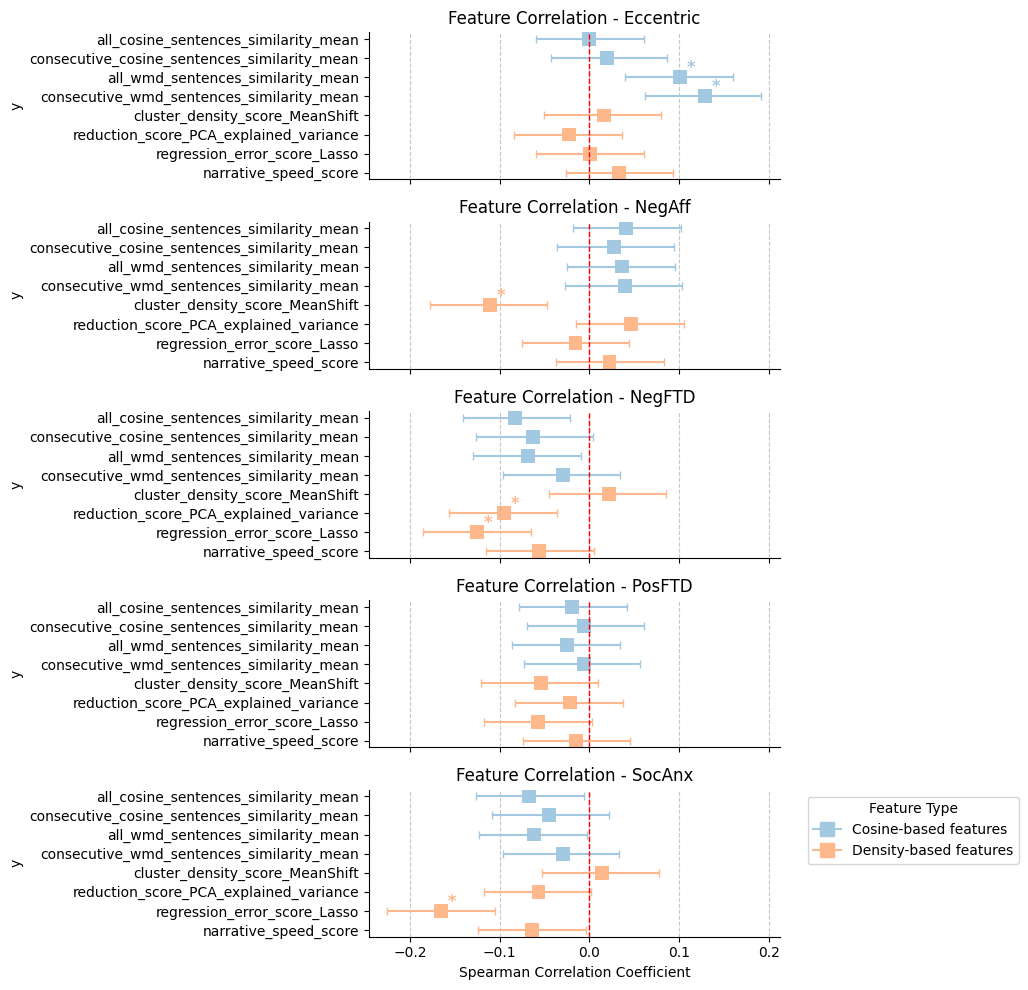

In [ ]:
plot_grouped_scatter(spearman_univariate_correlation,factors, correlation_name="Spearman")

#plot_grouped_scatter(skipped_univariate_correlation,factors, correlation_name="Skipped")
#plot_grouped_scatter(pearson_univariate_correlation,factors, correlation_name="Pearson")


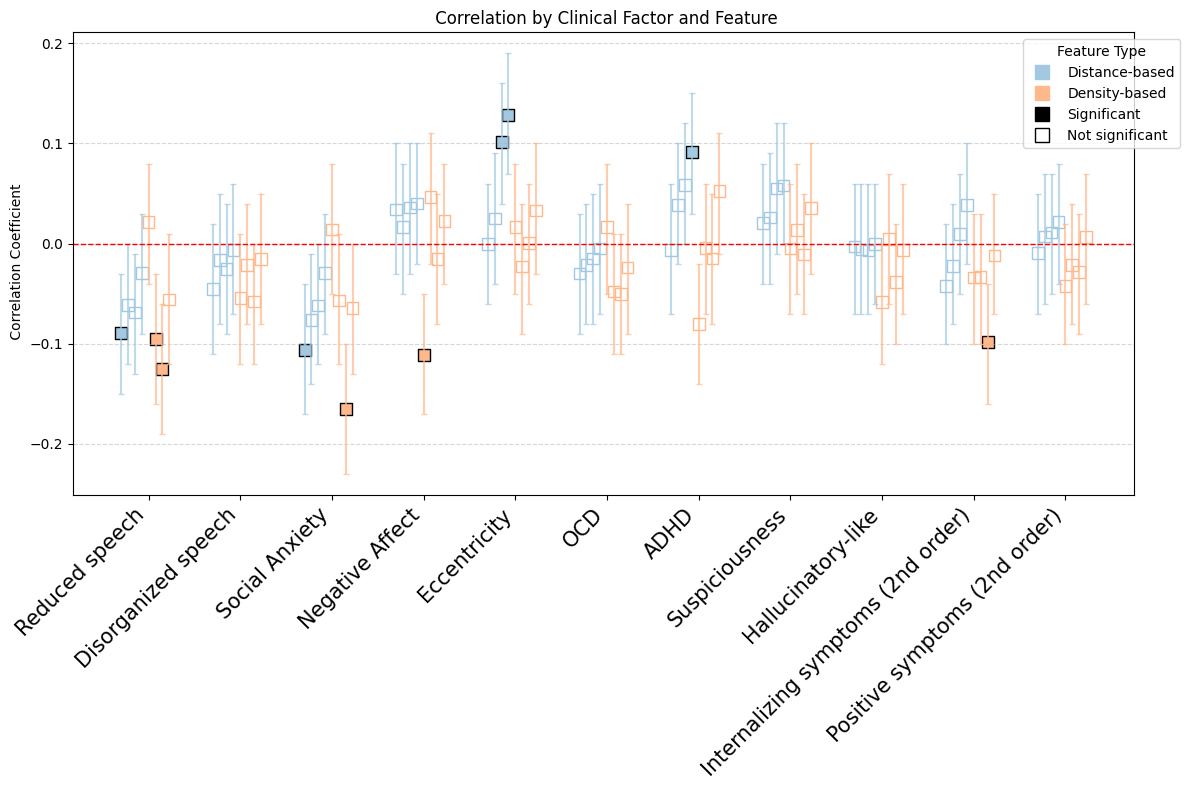

In [18]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd




def plot_grouped_features_by_dimension(df, target_list, correlation_name="",adj=True):
    # Filter to selected clinical factors
    df = df[df['x'].isin(target_list)].copy()
    
    # Define feature order and color mapping
    feature_order = [
        #'all_cosine_sentences_similarity_mean',
        "sentence_sim_all_cosine_sentences_similarity_mean",
        "sentence_sim_consecutive_cosine_sentences_similarity_mean",
        #'consecutive_cosine_sentences_similarity_mean',
        'all_wmd_sentences_similarity_mean',
        'consecutive_wmd_sentences_similarity_mean',
        'cluster_density_score_MeanShift',
        'reduction_score_PCA_explained_variance',
        'regression_error_score_Lasso',
        'narrative_speed_score'
    ]
    
    blue_features = {
        'all_cosine_sentences_similarity_mean',
        'consecutive_cosine_sentences_similarity_mean',
        "sentence_sim_all_cosine_sentences_similarity_mean",
        "sentence_sim_consecutive_cosine_sentences_similarity_mean",
        'all_wmd_sentences_similarity_mean',
        'consecutive_wmd_sentences_similarity_mean'
    }

    pastel_blue = '#A3C9E2'
    pastel_orange = '#FFB88C'

    # Add plotting metadata
    df = df[df['y'].isin(feature_order)]
    df['y'] = pd.Categorical(df['y'], categories=feature_order, ordered=True)
    df['color'] = df['y'].apply(lambda f: pastel_blue if f in blue_features else pastel_orange)
    df['significant'] = df['adjusted_p_value'] < 0.05
    if adj :
        df['err_low'] = df.apply(lambda row: row['r'] - row['CI95%_adj'][0], axis=1)
        df['err_high'] = df.apply(lambda row: row['CI95%_adj'][1] - row['r'], axis=1)

    else :
        df['err_low'] = df.apply(lambda row: row['r'] - row['CI95%'][0], axis=1)
        df['err_high'] = df.apply(lambda row: row['CI95%'][1] - row['r'], axis=1)

    # Map clinical factors to x positions
    factor_positions = {factor: i for i, factor in enumerate(target_list)}
    df['x_pos'] = df['x'].map(factor_positions)

    # Spread out feature points within each clinical factor group
    feature_offsets = {f: i for i, f in enumerate(feature_order)}
    offset_width = 0.6
    total_features = len(feature_order)
    df['x_jitter'] = df.apply(
        lambda row: row['x_pos'] + offset_width * ((feature_offsets[row['y']] - total_features / 2) / total_features),
        axis=1
    )

    # Plot
    fig, ax = plt.subplots(figsize=(max(12, len(target_list) * 0.75), 8))

    for _, row in df.iterrows():
        # Error bars
        ax.errorbar(
            x=row['x_jitter'], y=row['r'],
            yerr=[[row['err_low']], [row['err_high']]],
            fmt='none', ecolor=row['color'], capsize=2, alpha=0.7
        )

        # Significance-based shape fill
        if row['significant']:
            ax.scatter(
                row['x_jitter'], row['r'],
                facecolor=row['color'],
                edgecolor='black',
                s=70,
                marker='s',
                linewidth=1
            )
        else:
            ax.scatter(
                row['x_jitter'], row['r'],
                facecolor='none',
                edgecolor=row['color'],
                s=70,
                marker='s',
                linewidth=1
            )
        
        # Add feature names as text labels near each point
        if 0:
            ax.text(
                row['x_jitter'], row['r'] + 0.25,  # Add small offset to the y position
                row['y'], 
                fontsize=8, ha='center', va='center', 
                color=row['color'], 
                verticalalignment='bottom', 
                horizontalalignment='center', 
                alpha=0.8,
                rotation = 90
        )

    # Axes settings
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax.set_xticks(list(factor_positions.values()))
    ax.set_xticklabels(list(factor_positions.keys()), rotation=45, ha='right',fontsize = 15)
    ax.set_ylabel(f'{correlation_name} Correlation Coefficient')
    ax.set_title(f'{correlation_name} Correlation by Clinical Factor and Feature')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Legend
    legend_elements = [
        mlines.Line2D([], [], marker='s', color=pastel_blue, linestyle='None', markersize=10, label='Distance-based', markerfacecolor=pastel_blue),
        mlines.Line2D([], [], marker='s', color=pastel_orange, linestyle='None', markersize=10, label='Density-based', markerfacecolor=pastel_orange),
        mlines.Line2D([], [], marker='s', color='black', markerfacecolor='black', linestyle='None', markersize=10, label='Significant'),
        mlines.Line2D([], [], marker='s', color='black', markerfacecolor='none', linestyle='None', markersize=10, label='Not significant')
    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='best', title='Feature Type')

    plt.tight_layout()
    plt.savefig(f"{correlation_name}_grouped_clinical_scatter.png", dpi=800)
    plt.show()


# Clinical factor renaming (only for the known input codes)
factor_rename_map = {
        'NegFTD': 'Reduced speech',
        'PosFTD': 'Disorganized speech',
        'SocAnx': 'Social Anxiety',
        'NegAff': 'Negative Affect',
        'Eccentric': 'Eccentricity',
        "OCD" : "OCD",
        "ADHD":"ADHD",
        "Constrict":"Suspiciousness",
        "VivPercept": "Hallucinatory-like",
        "F1":"Internalizing symptoms (2nd order)",
        "F2":"Positive symptoms (2nd order)"
    }




feature_name_map = {
        'all_cosine_sentences_similarity_mean': 'Cosine Similarity (All)',
        "sentence_sim_all_cosine_sentences_similarity_mean":"Cosine Similarity (All)",
        "sentence_sim_consecutive_cosine_sentences_similarity_mean": "Cosine Similarity (Consecutive)",
        'consecutive_cosine_sentences_similarity_mean': 'Cosine Similarity (Consecutive)',
        'all_wmd_sentences_similarity_mean': 'WMD Similarity (All)',
        'consecutive_wmd_sentences_similarity_mean': 'WMD Similarity (Consecutive)',
        'cluster_density_score_MeanShift': 'Cluster Density (MeanShift)',
        'reduction_score_PCA_explained_variance': 'PCA Variance Unexplained',
        'regression_error_score_Lasso': 'Lasso Regression Error',
        'narrative_speed_score': 'Narrative Speed'
    }

spearman_univariate_correlation["x"] = spearman_univariate_correlation["x"].replace(factor_rename_map)

pretty_factors = [elt for elt in factor_rename_map.values()]

plot_grouped_features_by_dimension(spearman_univariate_correlation,pretty_factors, adj=False)

In [ ]:
merged_df.columns.tolist()

['subj',
 'Stim1_cinderella',
 'story_cinderella',
 'OCD_cinderella',
 'Cog&Percept_cinderella',
 'SocAnx_cinderella',
 'Eccentric_cinderella',
 'ADHD_cinderella',
 'Constrict_cinderella',
 'PosFTD_cinderella',
 'NegAff_cinderella',
 'NegFTD_cinderella',
 'HypoMania_cinderella',
 'VivPercept_cinderella',
 'F1_cinderella',
 'F2_cinderella',
 'cleaned_story_2_cinderella',
 'sentences_cinderella',
 'num_sentences_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_cinderella',
 'w2v_all_cosine_sentences_similarity_cinderella',
 'w2v_vectors_cinderella',
 'w2vwords_cinderella',
 'w2v_consecutive_wmd_sentences_similarity_cinderella',
 'w2v_all_wmd_sentences_similarity_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_mean_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_median_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_std_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_min_cinderella',
 'w2v_consecutive_cosine_sentences_similarity_max_ci

<Axes: xlabel='regression_error_score_Lasso', ylabel='NegFTD'>

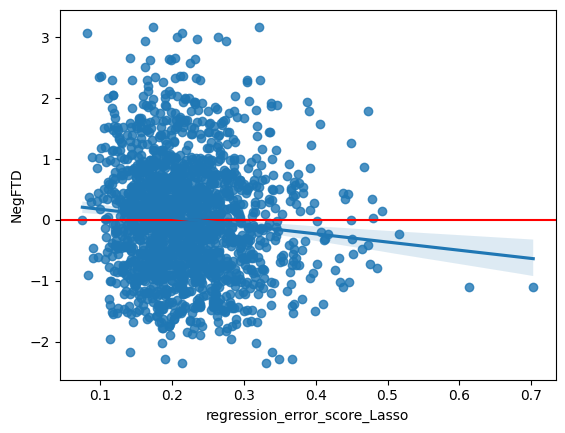

In [ ]:

import seaborn as sns

story = ""
plt.axhline(y=0, color = "red")
sns.regplot(data = combined_data,x = f"regression_error_score_Lasso{story}", y = f"NegFTD{story}")

In [ ]:
spearman_univariate_correlation

,x,y,n,r,CI95%,p-val,BF10,power,method,adjusted_p_value
0,NegAff,all_cosine_sentences_similarity_mean,984,0.040729,"[-0.02, 0.1]",0.201768,NaN,0.247884,spearman,0.422645
1,NegAff,consecutive_cosine_sentences_similarity_mean,984,0.02703,"[-0.04, 0.09]",0.397003,NaN,0.135384,spearman,0.635205
2,NegAff,all_wmd_sentences_similarity_mean,984,0.036031,"[-0.03, 0.1]",0.258818,NaN,0.204128,spearman,0.492986
3,NegAff,consecutive_wmd_sentences_similarity_mean,984,0.039881,"[-0.02, 0.1]",0.211323,NaN,0.239612,spearman,0.422645
4,NegAff,cluster_density_score_MeanShift,984,-0.110982,"[-0.17, -0.05]",0.000487,NaN,0.937249,spearman,0.004872
5,NegAff,reduction_score_PCA_explained_variance,984,0.046462,"[-0.02, 0.11]",0.145283,NaN,0.307772,spearman,0.341843
6,NegAff,regression_error_score_Lasso,984,-0.015415,"[-0.08, 0.05]",0.629113,NaN,0.077117,spearman,0.726587
7,NegAff,narrative_speed_score,984,0.022405,"[-0.04, 0.08]",0.482678,NaN,0.108095,spearman,0.667708
8,NegFTD,all_cosine_sentences_similarity_mean,984,-0.082482,"[-0.14, -0.02]",0.00964,NaN,0.735819,spearman,0.055086
9,NegFTD,consecutive_cosine_sentences_similarity_mean,984,-0.063018,"[-0.13, -0.0]",0.048127,NaN,0.50694,spearman,0.175008


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import pandas as pd

def plot_grouped_scatter_final(df, target_list, correlation_name=""):

    # Clinical factor renaming
    factor_rename_map = {
        'NegFTD': 'Reduced speech',
        'PosFTD': 'Disorganized speech',
        'SocAnx': 'Social Anxiety',
        'NegAff': 'Negative Affect',
        'Eccentric': 'Eccentricity'
    }

    feature_order = [
        'all_cosine_sentences_similarity_mean',
        'consecutive_cosine_sentences_similarity_mean',
        'all_wmd_sentences_similarity_mean',
        'consecutive_wmd_sentences_similarity_mean',
        'cluster_density_score_MeanShift',
        'reduction_score_PCA_explained_variance',
        'regression_error_score_Lasso',
        'narrative_speed_score'
    ]

    pastel_blue = '#A3C9E2'
    pastel_orange = '#FFB88C'

    blue_features = [
        'all_cosine_sentences_similarity_mean',
        'consecutive_cosine_sentences_similarity_mean',
        'all_wmd_sentences_similarity_mean',
        'consecutive_wmd_sentences_similarity_mean'
    ]

    # Filter and prepare data
    df = df[df['x'].isin(target_list)].copy()
    factor_positions = {factor: i for i, factor in enumerate(target_list)}
    #df['x_pretty'] = df['x'].map(factor_rename_map)
    #ordered_factors_pretty = [factor_rename_map[f] for f in target_list]
    #factor_positions = {factor: i for i, factor in enumerate(ordered_factors_pretty)}
    df['x_pos'] = df['x_pretty'].map(factor_positions)

    # Feature color and errors
    df['color'] = df['y'].apply(lambda x: pastel_blue if x in blue_features else pastel_orange)
    df['err_low'] = df.apply(lambda row: row['r'] - row['CI95%'][0], axis=1)
    df['err_high'] = df.apply(lambda row: row['CI95%'][1] - row['r'], axis=1)

    # Order features
    df['y'] = pd.Categorical(df['y'], categories=feature_order, ordered=True)
    feature_index_map = {feature: i for i, feature in enumerate(feature_order)}
    feature_count = len(feature_order)
    df['feature_offset'] = df['y'].map(feature_index_map)

    # Apply jitter within each group
    spacing = 0.09  # Adjust for how spread out the dots are within each factor
    df['x_jittered'] = df['x_pos'] + (df['feature_offset'] - feature_count / 2) * spacing

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))

    for _, row in df.iterrows():
        x_val = row['x_jittered']
        
        # Error bar
        ax.errorbar(
            x=x_val, y=row['r'],
            xerr=None,
            yerr=[[row['err_low']], [row['err_high']]],
            fmt='none', ecolor=row['color'], capsize=3, alpha=0.7
        )

        # Marker style
        is_significant = row['adjusted_p_value'] < 0.05
        facecolor = row['color'] if is_significant else 'none'
        edgecolor = row['color']

        # Plot point
        ax.scatter(
            x_val, row['r'],
            marker='s', s=100,
            facecolor=facecolor,
            edgecolor=edgecolor,
            linewidths=1,
            zorder=3
        )

        # Feature label
        ax.text(
            row['x_jitter'], row['r'] + 0.05,  # Add small offset to the y position
            row['y'], 
            fontsize=9, ha='center', va='center', 
            color=row['color'], fontweight='bold', 
            verticalalignment='bottom', 
            horizontalalignment='center', 
            alpha=0.8
        )

    # Axes & formatting
    ax.set_xticks(list(factor_positions.values()))
    ax.set_xticklabels(list(factor_positions.keys()), fontsize=11)
    ax.set_xlabel("Clinical Factor", fontsize=12)
    ax.set_ylabel(f"{correlation_name} Correlation Coefficient", fontsize=12)
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    sns.despine()

    # Legend
    filled_patch = mlines.Line2D([], [], marker='s', color='black', markerfacecolor='black', markersize=8, linestyle='None', label='Significant (p < 0.05)')
    hollow_patch = mlines.Line2D([], [], marker='s', color='black', markerfacecolor='none', markersize=8, linestyle='None', label='Non-significant')

    color_patch_blue = mlines.Line2D([], [], marker='s', color=pastel_blue, label='Cosine-based features', linestyle='None', markersize=10)
    color_patch_orange = mlines.Line2D([], [], marker='s', color=pastel_orange, label='Density-based features', linestyle='None', markersize=10)

    ax.legend(handles=[filled_patch, hollow_patch, color_patch_blue, color_patch_orange],
              bbox_to_anchor=(1.05, 1), loc='upper left', title='Legend')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)  # Leave space for feature labels
    plt.savefig(f"{correlation_name}_grouped_scatter_final.png", dpi=300)
    plt.show()





plot_grouped_scatter_final(spearman_univariate_correlation,factors)

KeyError: 'x_pretty'